In [1]:
## Lidar autocovariance function

In [2]:
import xarray as xr
import numpy as np
from scipy.signal import periodogram
from scipy.integrate import trapz
import pyart
%pylab inline


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119

Populating the interactive namespace from numpy and matplotlib


/home/rjackson/.conda/envs/spectra_env/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['trapz']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [3]:
acf_ds = xr.open_dataset('sgpdlacfC1.a1.20170630.201048.nc.v0')

In [4]:
acf_ds

<xarray.Dataset>
Dimensions:      (complex: 2, nlags: 20, nsamples: 4000, time: 169)
Coordinates:
  * time         (time) datetime64[ns] 2017-06-30T20:10:48.380000 ... 2017-06-30T20:16:01.580000
  * complex      (complex) int16 1 2
  * nlags        (nlags) int16 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19
Dimensions without coordinates: nsamples
Data variables:
    base_time    datetime64[ns] ...
    time_offset  (time) datetime64[ns] ...
    azimuth      (time) float32 ...
    elevation    (time) float32 ...
    acf_bkg      (nsamples, nlags, complex) float32 ...
    acf          (time, nsamples, nlags, complex) float32 ...
    lat          float32 ...
    lon          float32 ...
    alt          float32 ...
Attributes:
    command_line:          dlacf_ingest -s sgp -f C1 -D
    Conventions:           ARM-1.2
    process_version:       ingest-dlacf-1.0-0.el6
    dod_version:           dlacf-a1-1.0
    input_source:          /data/collection/sgp/sgpdlacfC1.00/aet_Stare_107_2...


In [5]:
acf_ds['time']

<xarray.DataArray 'time' (time: 169)>
array(['2017-06-30T20:10:48.380000000', '2017-06-30T20:10:49.930000000',
       '2017-06-30T20:10:51.470000000', '2017-06-30T20:10:53.020000000',
       '2017-06-30T20:10:54.560000000', '2017-06-30T20:10:56.100000000',
       '2017-06-30T20:10:57.650000000', '2017-06-30T20:10:59.190000000',
       '2017-06-30T20:11:00.730000000', '2017-06-30T20:11:02.280000000',
       '2017-06-30T20:11:03.820000000', '2017-06-30T20:11:05.360000000',
       '2017-06-30T20:11:06.910000000', '2017-06-30T20:11:08.450000000',
       '2017-06-30T20:11:09.990000000', '2017-06-30T20:11:11.530000000',
       '2017-06-30T20:11:13.080000000', '2017-06-30T20:11:14.620000000',
       '2017-06-30T20:11:16.160000000', '2017-06-30T20:11:17.700000000',
       '2017-06-30T20:11:19.240000000', '2017-06-30T20:11:20.780000000',
       '2017-06-30T20:11:22.330000000', '2017-06-30T20:11:23.870000000',
       '2017-06-30T20:11:25.410000000', '2017-06-30T20:11:26.960000000',
       '2017-

In [ ]:
my_spectra['acf_bkg']

In [ ]:
np.fft.ifft?

In [6]:
def get_psd(spectra):
    complex_coeff = spectra['acf'].sel(complex=1).values + spectra['acf'].sel(complex=2).values * 1j
    freq, power = periodogram(complex_coeff, axis=2, fs=50e6)
    inds_sorted = np.argsort(freq)
    spectra['power'] = xr.DataArray(power[:, :, inds_sorted], dims=(('time', 'nsamples', 'nlags')))
    spectra['freq_bins'] = xr.DataArray(freq[inds_sorted], dims=['nlags'])   
    complex_coeff = spectra['acf_bkg'].sel(complex=1).values + spectra['acf_bkg'].sel(complex=2).values * 1j
    freq, power = periodogram(complex_coeff, axis=1, fs=50e6)
    inds_sorted = np.argsort(freq)
    spectra['power_bkg'] = xr.DataArray(power[:, inds_sorted], dims=(('nsamples', 'nlags')))
    spectra.attrs['nyquist_velocity'] = 1548e-9/(4*1/50e6)
    return spectra

In [10]:
%time my_spectra = get_psd(acf_ds)

CPU times: user 1.89 s, sys: 118 ms, total: 2.01 s
Wall time: 1.32 s


In [11]:
def get_power_and_velocity(spectra):
    power = trapz(my_spectra['power'], axis=2, x=my_spectra['freq_bins'].values)
    freq_bins_tiled = np.tile(my_spectra['freq_bins'], (power.shape[0], power.shape[1], 1))
    print(freq_bins_tiled[2])
    frequency = 1/power*trapz(freq_bins_tiled*my_spectra['power'], x=my_spectra['freq_bins'].values, axis=2)
    power_bkg = trapz(my_spectra['power_bkg'], axis=1, x=my_spectra['freq_bins'])
    my_spectra['mean_power'] = xr.DataArray(power, dims=('time', 'nsamples'))
    my_spectra['mean_frequency'] = xr.DataArray(frequency, dims=('time', 'nsamples'))
    my_spectra['mean_velocity'] = 1548e-9*my_spectra['mean_frequency']
    my_spectra['mean_power_bkg'] = xr.DataArray(power_bkg, dims=('nsamples'))
    return power

In [13]:
%time power = get_power_and_velocity(my_spectra)

[[-25000000. -22500000. -20000000. ...  17500000.  20000000.  22500000.]
 [-25000000. -22500000. -20000000. ...  17500000.  20000000.  22500000.]
 [-25000000. -22500000. -20000000. ...  17500000.  20000000.  22500000.]
 ...
 [-25000000. -22500000. -20000000. ...  17500000.  20000000.  22500000.]
 [-25000000. -22500000. -20000000. ...  17500000.  20000000.  22500000.]
 [-25000000. -22500000. -20000000. ...  17500000.  20000000.  22500000.]]
CPU times: user 663 ms, sys: 40.2 ms, total: 703 ms
Wall time: 180 ms


In [63]:
def get_velocity_and_snr(spectra_ds, gate_resolution=60):
    num_samples = int(gate_resolution/3)
    sorts = np.argsort(my_spectra['mean_velocity'][0])
    vel_bins = np.linspace(
        -my_spectra.attrs['nyquist_velocity'], my_spectra.attrs['nyquist_velocity'], 40)
    vbins = (vel_bins[:-1]+vel_bins[1:])/2
    lin_power = my_spectra['mean_power']
    lin_power = np.reshape(
        lin_power.values, (int(lin_power.shape[0]), int(lin_power.shape[1]/num_samples), num_samples))
    velocity = np.reshape(my_spectra['mean_velocity'].values, lin_power.shape)
    power_spectra = np.zeros((lin_power.shape[0], lin_power.shape[1], len(vel_bins)-1))
    mean_vel = np.nan*np.ones((power_spectra.shape[0], power_spectra.shape[1]))
    power_bkg = np.reshape(my_spectra['mean_power_bkg'].values, (lin_power.shape[1], lin_power.shape[2]))
    power_bkg = np.tile(power_bkg, (lin_power.shape[0], 1, 1))
    power_weights = lin_power/power_bkg
    log_power = np.log10(power_weights)*10
    power_weights = np.where(log_power > 10, power_weights, 0)
    snr = np.zeros_like(mean_vel)
    for i in range(lin_power.shape[0]):
        for j in range(lin_power.shape[1]):
            power_spectra[i, j], bins = np.histogram(
                velocity[i, j],
                density=True, bins=vel_bins, weights=power_weights[i,j])
            if(np.any(power_weights[i,j] > 0)):
                 mean_vel[i,j] = vbins[np.argmax(power_spectra[i, j])]
            else:
                 mean_vel[i,j] = np.nan
    
    snr = log_power.mean(axis = 2)     
    spectra_ds['range'] = xr.DataArray(gate_resolution*np.arange(int(lin_power.shape[1])),
                                       dims=('range'))
    spectra_ds['bins'] = xr.DataArray(vbins, dims=('bins'))
    spectra_ds['doppler_velocity'] = xr.DataArray(mean_vel, dims=('time', 'range'))
    spectra_ds['snr'] = xr.DataArray(snr, dims=('time', 'range'))
    spectra_ds['power_spectral_density'] = xr.DataArray(power_spectra, dims=('time', 'range', 'bins'))
    return spectra_ds

In [64]:
%time spectra_ds = get_velocity_and_snr(my_spectra)

CPU times: user 2.5 s, sys: 11.7 ms, total: 2.51 s
Wall time: 1.9 s


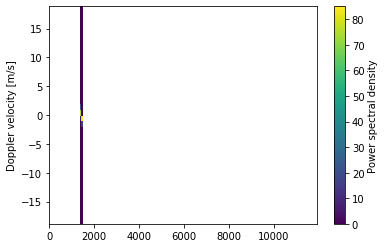

In [38]:
vbins = new_spectra_ds['bins']
x, y = np.meshgrid(new_spectra_ds['range'], vbins)
plt.pcolormesh(x, y, new_spectra_ds['power_spectral_density'][90].T*100)
plt.ylabel("Doppler velocity [m/s]")
ax = plt.colorbar()
ax.set_label("Power spectral density")

In [39]:
new_spectra_ds['doppler_velocity']

<xarray.DataArray 'doppler_velocity' (time: 169, range: 200)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
  * range    (range) int64 0 60 120 180 240 ... 11700 11760 11820 11880 11940
  * time     (time) datetime64[ns] 2017-06-30T20:10:48.380000 ... 2017-06-30T20:16:01.580000

(0, 3000)

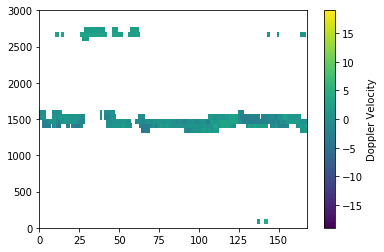

In [65]:
x, y = np.meshgrid(np.arange(new_spectra_ds['doppler_velocity'].values.shape[0]), new_spectra_ds['range'])
plt.pcolormesh(x, y, new_spectra_ds['doppler_velocity'].values.T , vmin=-19, vmax=19)
plt.colorbar(label='Doppler Velocity')
plt.ylim([0, 3000])

(0, 3000)

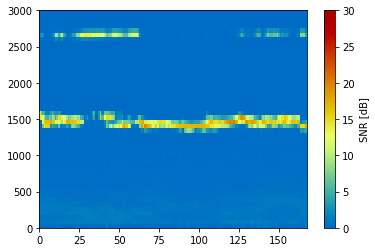

In [66]:
height_bins = 60*np.arange(new_spectra_ds['doppler_velocity'].values.shape[1])
x, y = np.meshgrid(np.arange(new_spectra_ds['doppler_velocity'].values.shape[0]), height_bins)
plt.pcolormesh(x, y, spectra_ds['snr'].values.T, vmin=0, vmax=30, cmap='pyart_HomeyerRainbow')
plt.colorbar(label='SNR [dB]')
plt.ylim([0, 3000])

In [52]:
new_spectra_ds['snr'].values.T[70]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [645]:
my_spectra

<xarray.Dataset>
Dimensions:         (complex: 2, nlags: 20, nsamples: 4000, time: 169)
Coordinates:
  * time            (time) datetime64[ns] 2017-06-30T20:10:48.380000 ... 2017-06-30T20:16:01.580000
  * nlags           (nlags) int64 0 1 2 3 4 5 6 7 8 ... 12 13 14 15 16 17 18 19
  * complex         (complex) int16 1 2
Dimensions without coordinates: nsamples
Data variables:
    base_time       datetime64[ns] ...
    time_offset     (time) datetime64[ns] ...
    azimuth         (time) float32 20.90088 20.90088 ... 20.900162 20.900162
    elevation       (time) float32 90.00288 90.0 90.0 ... 90.0 90.0 90.00144
    acf_bkg         (nsamples, nlags, complex) float32 ...
    acf             (time, nsamples, nlags, complex) float32 ...
    lat             float32 ...
    lon             float32 ...
    alt             float32 ...
    fft             (time, nsamples, nlags) complex64 (4148978+62272.375j) ... (63853492+6530590j)
    freq_bins       (nlags) float64 -2.5e+07 -2.25e+07 -2e+07 ..

In [632]:
mean_vel

array([[ 0.        , -1.98461538, -1.98461538, ..., -1.98461538,
        -1.98461538, -1.98461538],
       [ 0.        , -1.98461538, -1.98461538, ..., -1.98461538,
        -1.98461538, -1.98461538],
       [-0.99230769, -1.98461538, -1.98461538, ..., -1.98461538,
        -1.98461538, -1.98461538],
       ...,
       [-0.99230769, -1.98461538, -1.98461538, ..., -1.98461538,
        -1.98461538, -1.98461538],
       [-0.99230769, -1.98461538, -1.98461538, ..., -1.98461538,
        -1.98461538, -1.98461538],
       [-0.99230769, -1.98461538, -1.98461538, ..., -1.98461538,
        -1.98461538, -1.98461538]])